In [1]:
import sys
sys.path.insert(0, "mwcnn/")
sys.path.insert(0, "diffusion/")
sys.path.insert(0, "unet/")

import copy
import random
from collections import defaultdict
from typing import Callable, Optional

import numpy as np
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm

from src.dataset import get_splits, ImageDataset
from src.utils import plot_result, save_individual_results

from diffusion import get_pretrained as get_diffusion
from mwcnn import get_pretrained as get_mwcnn
from model import get_pretrained as get_unet

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.cuda.manual_seed(12345)

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may hav

In [2]:
def predict(model, x, normalize: str = "none"):
    """Returns predictions of model(x) according to the
    normalization strategy"""
    
    def apply_preprocessing(x: torch.Tensor,
                            pred: Optional[torch.Tensor] = None
                            ) -> tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Returns x processed according to `dset_config["normalize"]`.
        If pred is not None and `dset_config["normalize_output"]` is true,
        then it also returns `pred` with an inverse normalization operation.
        """

        if normalize == "standard":
            mean = torch.mean(x.reshape(x.size(0), -1), dim=1).view(x.size(0), 1, 1, 1)
            std = torch.std(x.reshape(x.size(0), -1), dim=1).view(x.size(0), 1, 1, 1)
            x = (x - mean)/std
            if pred is not None:
                pred = pred*std + mean
            return x, pred
        if normalize == "minmax":
            mi = torch.min(x.reshape(x.size(0), -1), dim=1).values.view(x.size(0), 1, 1, 1)
            ma = torch.max(x.reshape(x.size(0), -1), dim=1).values.view(x.size(0), 1, 1, 1)
            x = (x - mi)/(ma - mi)
            if pred is not None:
                pred = pred*(ma - mi) + mi
            return x, pred
        return x, pred

    x_processed, _ = apply_preprocessing(x)
    pred_processed = model(x_processed)
    _, pred = apply_preprocessing(x, pred_processed)
    return pred

In [3]:
def evaluate(model: Callable[[torch.Tensor], torch.Tensor], dataset: ImageDataset,
             im_size: int = 1024, max_val: int = 16800, batch_size: int = 8,
             normalize: str = "none", dtype: torch.dtype = torch.float) -> dict[str, float]:
    """
    Returns a dict with evaluation metrics of the `model` in the `dataset`.
    The `model` will need to be a function that takes a batch of images
    (i.e. size [batch_size, 1, 1024, 1024]) and returns the unnoised image (tensor of the
    same size).

    The `dset_config` should potentially be a dict with a "normalize" key and
    "normalize_output" key, that will indicate the dataset configuration
    used by `model` during training.
    """

    dataset = copy.deepcopy(dataset)
    dataset.default_transformation = v2.Compose([v2.ToTensor(), v2.ToDtype(torch.float32)])
    assert dataset.normalize == "none"
    loader = DataLoader(dataset, batch_size=batch_size)
    metrics = defaultdict(list)
    for sample in (pbar := tqdm(loader, desc="Evaluating")):
        x = sample["input_image"]
        y = sample["output_image"]
        assert x.size() == y.size()
        assert x.size(2) % im_size == 0
        assert x.size(3) % im_size == 0
        for i in range(0, x.size(2), im_size):
            for j in range(0, x.size(3), im_size):
                x_cropped = x[:, :, i : i+im_size, j : j+im_size]
                y_cropped = y[:, :, i : i+im_size, j : j+im_size]

                pred = predict(model, x_cropped.to(DEVICE), normalize=normalize).cpu()

                dif = (pred - y_cropped).view(batch_size, -1)
                mse = torch.mean(dif**2, dim=1)
                mae = torch.mean(torch.abs(dif), dim=1)
                psnr = torch.where(mse == 0, 100, 20*torch.log10(max_val/torch.sqrt(mse)))

                metrics["mse"] += mse.tolist()
                metrics["mae"] += mae.tolist()
                metrics["psnr"] += psnr.tolist()

                pbar.set_postfix(psnr=np.mean(metrics["psnr"]))
    return {metric: np.mean(vals) for metric, vals in metrics.items()}

In [4]:
_, dset_test = get_splits("data", normalize="none")

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [5]:
# Get random subsample to use in the predictions.
subsample = Subset(dset_test, random.choices(list(range(len(dset_test))), k=4))
mip = []
edof = []
for batch in subsample:
    mip.append(batch["input_image"])
    edof.append(batch["output_image"])
mip = torch.stack(mip)
edof = torch.stack(edof)
mip.shape

torch.Size([4, 1, 1024, 1024])

In [6]:
print("Evaluating identity")
evaluate(lambda x: x, dset_test)

Evaluating identity


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

{'mse': 19145.713037967682,
 'mae': 76.96297599719121,
 'psnr': 49.14588334927192}

## 1. Evaluate diffusion

In [11]:
print("Evaluating diffusion")
model = get_diffusion().to(DEVICE).eval().requires_grad_(False).float()
evaluate(model.predict, dset_test, normalize="minmax")

Evaluating diffusion


/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

{'mse': 27152.978301525116,
 'mae': 79.39999622794298,
 'psnr': 46.519822982641365}

In [23]:
# Get diffusion predictions.
diffusion = []
for x in tqdm(mip, desc="Predicting"):
    diffusion.append(predict(model.predict, x.unsqueeze(0).to(DEVICE), normalize="minmax").squeeze(0).cpu().float())
diffusion = torch.stack(diffusion)
diffusion.shape

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([4, 1, 1024, 1024])

## 2. Evaluate MWCNN

In [12]:
print("Evaluating mwcnn with fft")
fft_mwcnn_model = get_mwcnn("mwcnn/models/fft_mwcnn_feats_32.pt").to(DEVICE).eval().requires_grad_(False).float()
evaluate(fft_mwcnn_model.predict, dset_test, normalize="minmax")

Evaluating mwcnn with fft


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

{'mse': 48980.21719684968, 'mae': 77.81553188768717, 'psnr': 43.03784537773866}

In [13]:
# Get mwcnn fft predictions.
mwcnn_fft = []
for x in tqdm(mip, desc="Predicting"):
    mwcnn_fft.append(predict(fft_mwcnn_model.predict, x.unsqueeze(0).to(DEVICE), normalize="minmax").squeeze(0).cpu().float())
mwcnn_fft = torch.stack(mwcnn_fft)
mwcnn_fft.shape

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([4, 1, 1024, 1024])

In [14]:
print("Evaluating mwcnn")
mwcnn_model = get_mwcnn("mwcnn/models/none_mwcnn_feats_32.pt").to(DEVICE).eval().requires_grad_(False)
evaluate(mwcnn_model.predict, dset_test, normalize="minmax")

Evaluating mwcnn


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

{'mse': 5422.693167851521, 'mae': 39.09624602359075, 'psnr': 53.72623804899362}

In [15]:
# Get mwcnn predictions.
mwcnn = []
for x in tqdm(mip, desc="Predicting"):
    mwcnn.append(predict(mwcnn_model.predict, x.unsqueeze(0).to(DEVICE), normalize="minmax").squeeze(0).cpu().float())
mwcnn = torch.stack(mwcnn)
mwcnn.shape

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([4, 1, 1024, 1024])

## 3. Evaluate Unet

In [ ]:
print("Evaluating Unet")
unet_model = get_unet("unet/models/Seif-UNet-[16, 32, 64, 128, 256].pt").to(DEVICE).eval().requires_grad_(False)
evaluate(unet_model.predict, dset_test, normalize="")

In [ ]:
# Get unet predictions.
unet = []
for x in tqdm(mip, desc="Predicting"):
    unet.append(predict(unet_model.predict, x.unsqueeze(0).to(DEVICE), normalize="minmax").squeeze(0).cpu().float())
unet = torch.stack(unet)
unet.shape

## 4. Plot results

In [ ]:
# Now plot everything.
results = [
    {
        "MIP": mip[0].numpy(), 
        "EDOF": edof[0].numpy(), 
        "Diffusion": diffusion[0].numpy(),
        "FFT_MWCNN": mwcnn_fft[0].numpy(),
        "MWCNN": mwcnn[0].numpy(),
        "unet": unet[0].numpy(),}
    for (mip, edof, diffusion, mwcnn_fft, 
         mwcnn, unet) in zip(mip, edof, diffusion, mwcnn_fft, 
                                             mwcnn, unet)
]
plot_result(results, "Summary.png")

## 5. Save images

In [ ]:
save_individual_results(results, save_path="results/")

## 6. Gan
As images are smaller, separate comparison

In [ ]:
_, dset_test = get_splits("data", normalize="none", image_size=256)
# Get random subsample to use in the predictions.
subsample = Subset(dset_test, random.choices(list(range(len(dset_test))), k=4))
mip = []
edof = []
for batch in subsample:
    mip.append(batch["input_image"])
    edof.append(batch["output_image"])
mip = torch.stack(mip)
edof = torch.stack(edof)
mip.shape

In [ ]:
print("Evaluating identity")
evaluate(lambda x: x, dset_test)

### 6.1 mwcnn gan

In [9]:
print("Evaluating mwcnn")
mwcnn_model = get_mwcnn("gan/models/none_mwcnn_feats_64.pt", n_feats=64).to(DEVICE).eval().requires_grad_(False)
evaluate(mwcnn_model.predict, dset_test, im_size=256, normalize="minmax")

Evaluating mwcnn


/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB (GPU 0; 14.58 GiB total capacity; 11.66 GiB already allocated; 1.68 GiB free; 11.95 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
# Get mwcnn predictions.
pre_gan_mwcnn = []
for x in tqdm(mip, desc="Predicting"):
    pre_gan_mwcnn.append(predict(mwcnn_model.predict, x.unsqueeze(0).to(DEVICE), normalize="minmax").squeeze(0).cpu().float())
pre_gan_mwcnn = torch.stack(pre_gan_mwcnn)
pre_gan_mwcnn.shape

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([4, 1, 1024, 1024])

In [ ]:
print("Evaluating gan mwcnn")
mwcnn_model = get_mwcnn("gan/models/mwcnn_none_gan.pt", n_feats=64).to(DEVICE).eval().requires_grad_(False)
evaluate(mwcnn_model.predict, dset_test, im_size=256, normalize="minmax")

In [ ]:
# Get mwcnn predictions.
post_gan_mwcnn = []
for x in tqdm(mip, desc="Predicting"):
    post_gan_mwcnn.append(predict(mwcnn_model.predict, x.unsqueeze(0).to(DEVICE), normalize="minmax").squeeze(0).cpu().float())
post_gan_mwcnn = torch.stack(post_gan_mwcnn)
post_gan_mwcnn.shape

### 6.2 Unet gan

In [18]:
print("Evaluating unet")
unet_model = get_unet("gan/models/UNet-[16, 32, 64, 128, 256].pt").to(DEVICE).eval().requires_grad_(False)
evaluate(unet_model.predict, dset_test, im_size=256, normalize="minmax")

Evaluating unet


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

{'mse': 5300.551951078268,
 'mae': 36.52050241827965,
 'psnr': 54.121482152205246}

In [19]:
# Get unet predictions.
pre_gan_unet = []
for x in tqdm(mip, desc="Predicting"):
    pre_gan_unet.append(predict(unet_model.predict, x.unsqueeze(0).to(DEVICE), normalize="minmax").squeeze(0).cpu().float())
pre_gan_unet = torch.stack(pre_gan_unet)
pre_gan_unet.shape

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([4, 1, 1024, 1024])

In [20]:
print("Evaluating unet gan")
unet_model = get_unet("gan/models/GAN_UNet-[16, 32, 64, 128, 256].pt").to(DEVICE).eval().requires_grad_(False)
evaluate(unet_model.predict, dset_test, im_size=256, normalize="minmax")

Evaluating unet gan


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

{'mse': 5124.357825141687, 'mae': 36.71767859619398, 'psnr': 54.20022356510162}

In [21]:
post_gan_unet = []
for x in tqdm(mip, desc="Predicting"):
    post_gan_unet.append(predict(unet_model.predict, x.unsqueeze(0).to(DEVICE), normalize="minmax").squeeze(0).cpu().float())
post_gan_unet = torch.stack(post_gan_unet)
post_gan_unet.shape

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([4, 1, 1024, 1024])

## 7. Plot gan results

/tmp/ipykernel_3117/772330519.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


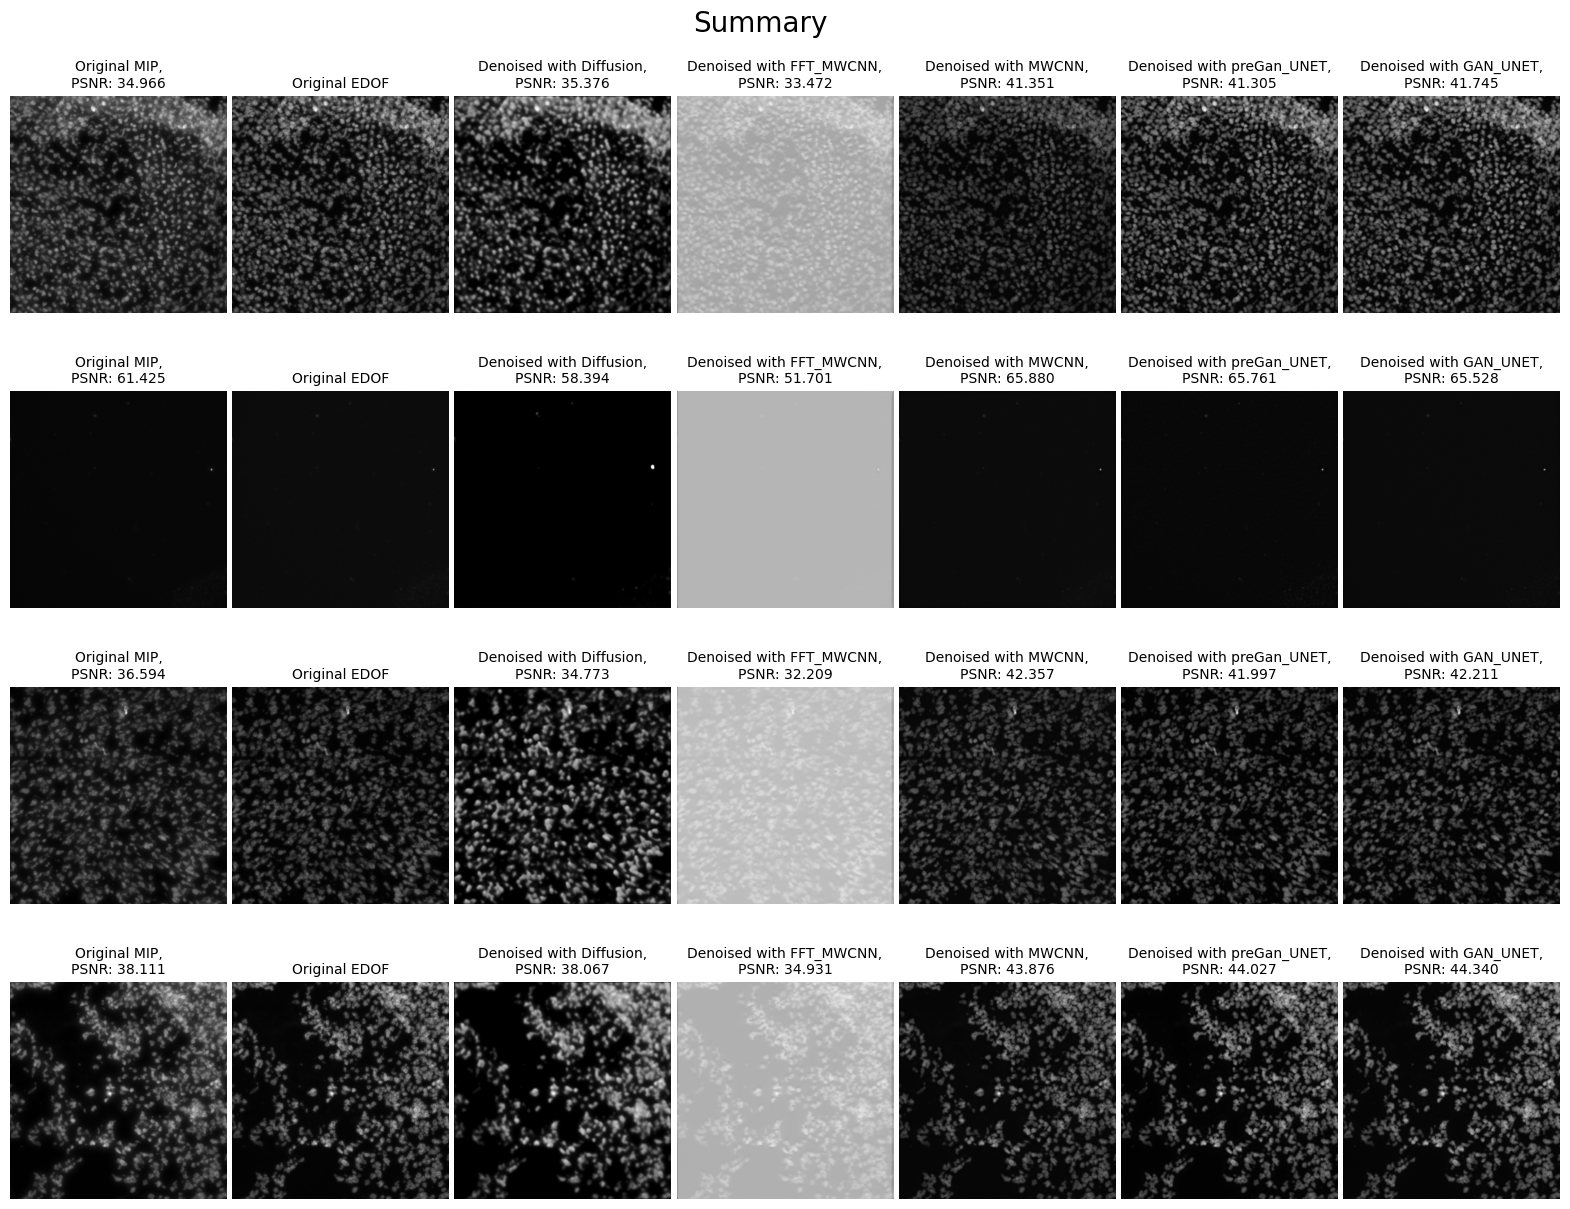

In [29]:
# Now plot everything.
results = [
    {
        "MIP": mip[0].numpy(), 
        "EDOF": edof[0].numpy(), 
        "Unet": pre_gan_unet[0].numpy(),
        "gan_unet": post_gan_unet[0].numpy(),
        "MWCNN": pre_gan_mwcnn[0].numpy(),
        "gan_mwcnn": post_gan_unet[0].numpy(),}
    for (mip, edof, pre_gan_unet, post_gan_unet, 
         pre_gan_mwcnn, post_gan_unet) in zip(mip, edof, pre_gan_unet, post_gan_unet, 
                                             pre_gan_mwcnn, post_gan_unet)
]
plot_result(results, "GAN_summary.png")


## 7. Save images

In [ ]:
save_individual_results(results, save_path="results/gan_")